We will try to predict top 5 scores here

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [75]:
data = pd.read_csv("../data/merged_data.csv")

In [76]:
data.dropna(axis=0,subset=["%"],inplace=True)
data = data[data["Rang"] <= 5]
data.reset_index(drop=True,inplace=True)

Encoding categorical variables

In [77]:
X = data[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
y = data[['%']].astype(float)

In [7]:
import sklearn.preprocessing

encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
X = pd.concat([X,pd.DataFrame(encoder.fit_transform(X[['Pos']]),columns=encoder.categories_)],axis=1)
X.drop("Pos",axis=1,inplace=True)

X = pd.concat([X,pd.DataFrame(encoder.fit_transform(X[['Nation']]),columns=encoder.categories_)],axis=1)
X.drop("Nation",axis=1,inplace=True)


Train test split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [97]:
print(X_train.shape,X_test.shape)

(72, 45) (31, 45)


Preprocessing

In [9]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns=X_test.columns)

C:\Users\charl\miniconda3\envs\BallondOr\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\charl\miniconda3\envs\BallondOr\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\charl\miniconda3\envs\BallondOr\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\charl\miniconda3\envs\BallondOr\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An er

Data Augmentation

In [10]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

In [11]:
X_train_augmented, y_train_augmented = noise(X_train, y_train,35, 2)

In [149]:
X_train_augmented.shape

(2592, 45)

Model building

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear_regression = cross_val_score(LinearRegression(), X_train_augmented, y_train_augmented, cv=10,scoring='neg_root_mean_squared_error')


## Linear Regression

Validation RMSE : 9.584019262372525 (61.15124480676028% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


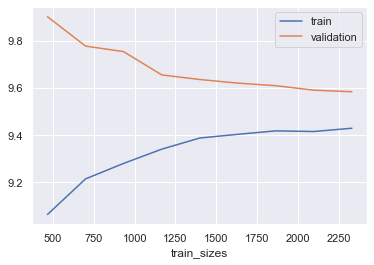

In [25]:
print("Validation RMSE : "+str(abs(linear_regression.mean()))+ " ("+str(abs(linear_regression.mean()*100/y_train_augmented.mean()))+"% of the mean)")
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(LinearRegression(), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

#### Predicting with not augmented data :

In [33]:
abs(cross_val_score(LinearRegression(), X_train, y_train, cv=10,scoring='neg_root_mean_squared_error').mean()*100/y_train['%'].mean())

74.45071868045434

**Data augmentation gives -13% on RMSE !**

#### Standardizing data :

In [34]:
numeric_variables = ['Age',           'Min_Playing',
                         'Gls',                   'Ast',
                        'CrdY',                  'CrdR']

In [40]:
X_train_augmented.dtype

dtype('float64')

In [43]:
from sklearn.preprocessing import StandardScaler

X_train_s = X_train
X_train_s[numeric_variables] = StandardScaler().fit_transform(X_train[numeric_variables])

In [50]:
X_train_s

,Age,Min_Playing,Gls,Ast,CrdY,CrdR,winner_Bundesliga,winner_C3,finalist_C3,winner_UCL,...,"(EGY,)","(ENG,)","(ESP,)","(FRA,)","(GER,)","(ITA,)","(NED,)","(POR,)","(SEN,)","(URU,)"
0,0.814999,-2.646787,-0.454344,-0.393277,-1.471918,-0.459795,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.368583,-0.497855,0.668153,-0.393277,-0.077469,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.306128,-0.207324,-1.336306,-1.639454,-1.471918,-0.459795,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.538207,0.589133,-0.855236,2.306774,-0.077469,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.368583,0.356207,-1.336306,-1.639454,-0.077469,1.487573,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.261415,1.618517,-1.015593,-1.224062,-1.123306,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,-0.015377,0.120777,-0.694879,-0.808669,-1.123306,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,-0.845754,0.301106,1.149223,2.306774,-0.426081,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,-0.292169,-0.537929,0.026726,1.268293,0.271143,-0.459795,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
abs(cross_val_score(LinearRegression(), X_train_s, y_train, cv=10,scoring='neg_root_mean_squared_error').mean()*100/y_train['%'].mean())

74.45071868045423

Ridge Regression

In [26]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

ridge = RidgeCV(alphas = np.linspace(5000,50000),cv=10,scoring='neg_root_mean_squared_error').fit(X_train_augmented,y_train_augmented)
print(ridge.alpha_)
ridge = cross_val_score(Ridge(ridge.alpha_),X_train_augmented, y_train_augmented,cv=10,scoring='neg_root_mean_squared_error')

6836.734693877551


Validation RMSE : 9.549090078591595 (60.92837765574422% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


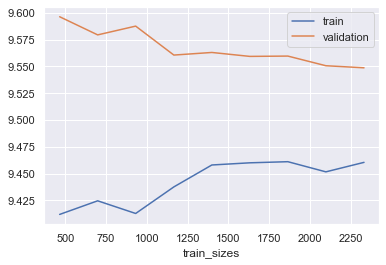

In [27]:
print("Validation RMSE : "+str(abs(ridge.mean()))+ " ("+str(abs(ridge.mean()*100/y_train_augmented.mean()))+"% of the mean)")

N, train_score, val_score = learning_curve(Ridge(alpha=6836.734693877551), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

Lasso regression

In [28]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

lasso = LassoCV(alphas = np.linspace(-5,5),random_state=0,cv=10).fit(X_train_augmented,y_train_augmented)
print(lasso.alpha_)
lasso = cross_val_score(Lasso(lasso.alpha_),X_train_augmented, y_train_augmented,cv=10,scoring='neg_root_mean_squared_error')

0.7142857142857144


Validation RMSE : 9.551758046979613 (60.94540074215149% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


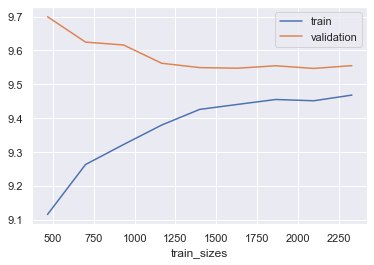

In [29]:
print("Validation RMSE : "+str(abs(lasso.mean()))+ " ("+str(abs(lasso.mean()*100/y_train_augmented.mean()))+"% of the mean)")

N, train_score, val_score = learning_curve(Lasso(alpha=0.3061224489795915), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

Polynomial Regression

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [31]:
poly = PolynomialFeatures(degree=2)
X_train_augmented_ = poly.fit_transform(X_train_augmented)

poly_regression = cross_val_score(LinearRegression(),X_train_augmented_,y_train_augmented,cv=10,scoring="neg_root_mean_squared_error")

Validation RMSE : 12.137691374691315 (77.44505893855131% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


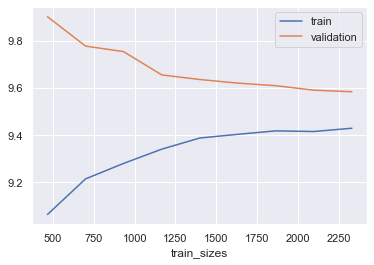

In [32]:
print("Validation RMSE : "+str(abs(poly_regression.mean()))+ " ("+str(abs(poly_regression.mean()*100/y_train_augmented.mean()))+"% of the mean)")

N, train_score, val_score = learning_curve(LinearRegression(), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

let's tyy to reduce model complexity (to reduce overfit) by doing an OrdinalEncoder instead of OneHotEncoder

In [51]:
X = data[['Nation', 'Pos', 'Age', 'Min_Playing', 'Gls', 'Ast',
       'CrdY', 'CrdR','winner_Bundesliga',
       'winner_C3', 'finalist_C3', 'winner_UCL', 'finalist_UCL',
       'winner_Club WC', 'finalist_Club WC', 'winner_Copa America',
       'finalist_Copa America', 'winner_Euro', 'finalist_Euro', 'winner_Liga',
       'winner_Ligue 1', 'winner_PL', 'winner_Serie A', 'winner_WC',
       'finalist_WC']]
y = data[['%']].astype(float)

In [59]:
encoder = sklearn.preprocessing.OrdinalEncoder()
X['Pos'] = encoder.fit_transform(X[['Pos']])
X['Nation'] = encoder.fit_transform(X[['Nation']])

train test split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [63]:
X_train.shape

(72, 25)

Preprocessing

In [62]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test),columns=X_test.columns)

Data augmentation

In [64]:
X_train_augmented, y_train_augmented = noise(X_train, y_train,35, 2)

In [65]:
X_train_augmented.shape

(2592, 25)

## Linear Regression

In [66]:
linear_regression = cross_val_score(LinearRegression(), X_train_augmented, y_train_augmented, cv=10,scoring='neg_root_mean_squared_error')

Validation RMSE : 9.539762712120748 (60.86886399505069% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


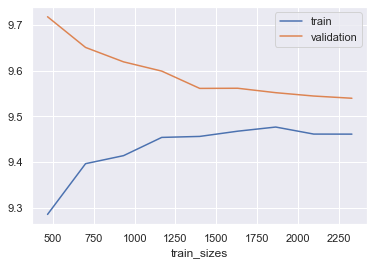

In [67]:
print("Validation RMSE : "+str(abs(linear_regression.mean()))+ " ("+str(abs(linear_regression.mean()*100/y_train_augmented.mean()))+"% of the mean)")
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(LinearRegression(), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

## Ridge

In [69]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

ridge = RidgeCV(alphas = np.linspace(1000,5000),cv=10,scoring='neg_root_mean_squared_error').fit(X_train_augmented,y_train_augmented)
print(ridge.alpha_)
ridge = cross_val_score(Ridge(ridge.alpha_),X_train_augmented, y_train_augmented,cv=10,scoring='neg_root_mean_squared_error')

3693.877551020408


Validation RMSE : 9.528095945217547 (60.79442368984366% of the mean)
[ 233  466  699  932 1166 1399 1632 1865 2098 2332]


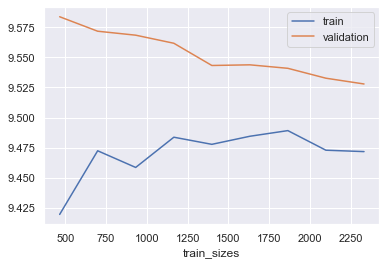

In [70]:
print("Validation RMSE : "+str(abs(ridge.mean()))+ " ("+str(abs(ridge.mean()*100/y_train_augmented.mean()))+"% of the mean)")

N, train_score, val_score = learning_curve(Ridge(alpha=3693.877551020408), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

## Lasso

In [71]:
lasso = LassoCV(alphas = np.linspace(-5,5),random_state=0,cv=10).fit(X_train_augmented,y_train_augmented)
print(lasso.alpha_)
lasso = cross_val_score(Lasso(lasso.alpha_),X_train_augmented, y_train_augmented,cv=10,scoring='neg_root_mean_squared_error')

0.3061224489795915


[ 233  466  699  932 1166 1399 1632 1865 2098 2332]
Training RMSE : 9.481342237949985 (60.49610966099283% of the mean)
Validation RMSE : 9.537453746541921 (60.85413154142181% of the mean)


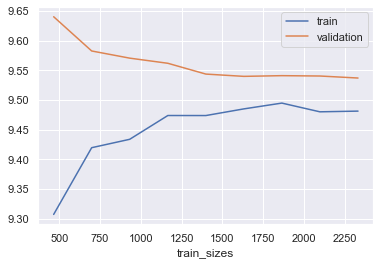

In [74]:
N, train_score, val_score = learning_curve(Lasso(alpha=0.3061224489795915), X_train_augmented,y_train_augmented, train_sizes=np.linspace(0.1,1,10),cv=10,scoring='neg_root_mean_squared_error')
print(N)
plt.plot(N[1:], abs(train_score.mean(axis=1))[1:],label="train")
plt.plot(N[1:], abs(val_score.mean(axis=1))[1:], label="validation")
plt.xlabel('train_sizes')
plt.legend()

print("Training RMSE : "+str(abs(train_score.mean(axis=1))[9])+ " ("+str(abs(train_score.mean(axis=1))[9]*100/y_train_augmented.mean())+"% of the mean)")
print("Validation RMSE : "+str(abs(lasso.mean()))+ " ("+str(abs(lasso.mean()*100/y_train_augmented.mean()))+"% of the mean)")